In [1]:
#%env XLA_PYTHON_CLIENT_PREALLOCATE=false
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform


env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


In [2]:
import os
import sys
import jax
#jax.config.update("jax_enable_x64", True)
sys.path.append('../synax/')

import synax
import jax.numpy as jnp
import interpax
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

In [3]:
#key = jax.random.key(42)
#B_key,C_key =jax.random.split(key)
#B_field = jax.random.normal(B_key,(512,512,256),)
#C_field = jax.random.normal(C_key,(512,512,256),)

In [4]:
@jax.jit
def C_page(x:float,y:float,z:float,C0:float = 1.,hr:float=5,hd:float=1):
    #x = x
    #z = z
    #c = (x**2+y**2+z**2)/jnp.max(jnp.array([x**2+y**2+z**2,9.]))+1e-7
    
    return C0*jnp.exp(-jnp.sqrt(x**2+y**2)/hr)/jnp.cosh(z/hd)**2#*(1-jnp.floor(c))


def C_uni(x:float,y:float,z:float,C0:float = 1.,):
    x = x+8.3
    z = z-0.06
    c = (x**2+y**2+z**2)/jnp.max(jnp.array([x**2+y**2+z**2,9.]))+1e-7
    return 1-jnp.floor(c)

R_obs = (8.3**2+0.006**2)**0.5

def C_sun(x:float,y:float,z:float,C0:float = 6.4e1,):
    z = jnp.abs(z)
    factor1 = 1-jnp.floor(z/jnp.max(jnp.array([z,1])))
    R = (x**2+y**2)**0.5
    C = C0*jnp.exp(-(R-R_obs)/8-z)
    
    return factor1*C

C_earth = C_page(-8.3,0,0.06)
C_page_vmap = jax.vmap(lambda x,y,z:C_page(x,y,z))
C_uni_vmap = jax.vmap(lambda x,y,z:C_uni(x,y,z))
C_sun_vmap = jax.vmap(lambda x,y,z:C_sun(x,y,z))

'''def B_page(x:float,y:float,z:float,B0:float = 4.,chi0:float = 0.43633232,psi0:float = 0.47123888,psi1:float=0.01570796,hphi:float=8,hchi:float=1):
    r = jnp.sqrt(x**2+y**2)
    phi = jnp.atan2(x,y)
    psi_r = psi_0+psi_1*jnp.log()
    return '''

2024-06-27 17:45:37.831221: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


'def B_page(x:float,y:float,z:float,B0:float = 4.,chi0:float = 0.43633232,psi0:float = 0.47123888,psi1:float=0.01570796,hphi:float=8,hchi:float=1):\n    r = jnp.sqrt(x**2+y**2)\n    phi = jnp.atan2(x,y)\n    psi_r = psi_0+psi_1*jnp.log()\n    return '

In [5]:
xs,step = jnp.linspace(-20,20,256,endpoint=False,retstep=True)
xs = xs + step*0.5

ys,step = jnp.linspace(-20,20,256,endpoint=False,retstep=True)
ys = ys + step*0.5

zs,step = jnp.linspace(-5,5,64,endpoint=False,retstep=True)
zs = zs + step*0.5

In [6]:
coords = jnp.meshgrid(xs,ys,zs,indexing='ij')
coords[0].shape

(256, 256, 64)

In [7]:
%%time
C_field = C_page_vmap(coords[0].reshape(-1),coords[1].reshape(-1),coords[2].reshape(-1))*6.4e1/C_earth
#C_field = C_uni_vmap(coords[0].reshape(-1),coords[1].reshape(-1),coords[2].reshape(-1))#*6.4e1/C_earth
C_field = C_field.reshape((256,256,64))

CPU times: user 80.5 ms, sys: 15.6 ms, total: 96.1 ms
Wall time: 184 ms


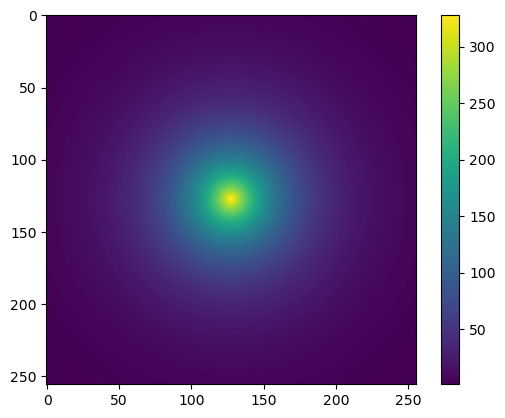

In [8]:
plt.imshow(C_field[:,:,32])
plt.colorbar()

In [26]:
dtype = np.float64  # 64-bit floating point

# Read the binary file
breg = np.fromfile('../../SyncEmiss/breg.bin', dtype=dtype).reshape((256,256,64,3))
brnd = np.fromfile('../../SyncEmiss/brnd.bin', dtype=dtype).reshape((256,256,64,3))*0

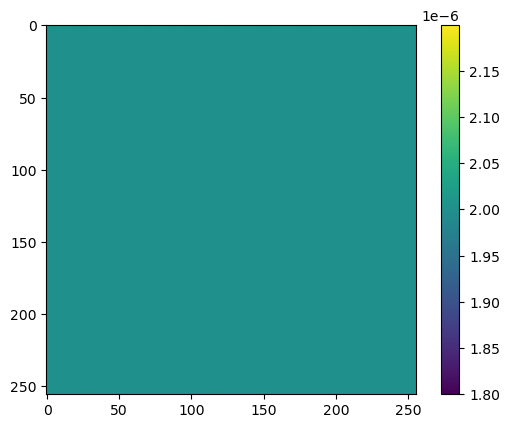

In [40]:
B_field = jnp.array(breg+brnd)
#B_field = jnp.ones_like(breg+brnd)*jnp.array([1.,0.,0.])*1e-6
#B_field = jnp.stack([C_field] * 3, axis=0).transpose(1,2,3,0)*1e-6*6
#C_field = jnp.ones_like(C_field)
B_field_square = (B_field**2).sum(axis=-1)
plt.imshow(B_field[:,:,32,2])
plt.colorbar()

In [28]:
def obtain_nhat(x:float,y:float,z:float,obs_coord:tuple[float] = (-8.3,0.,0.006)):
    x_rel = x - obs_coord[0]
    y_rel = y - obs_coord[1]
    z_rel = z - obs_coord[2]
    r = (x_rel**2+y_rel**2+z_rel**2)**0.5
    return jnp.array([x_rel,y_rel,z_rel])/r

obtain_nhat_vamp = jax.vmap(lambda x,y,z:obtain_nhat(x,y,z))

In [29]:
nhats = obtain_nhat_vamp(coords[0].reshape(-1),coords[1].reshape(-1),coords[2].reshape(-1))
nhats = nhats.reshape((256,256,64,3))

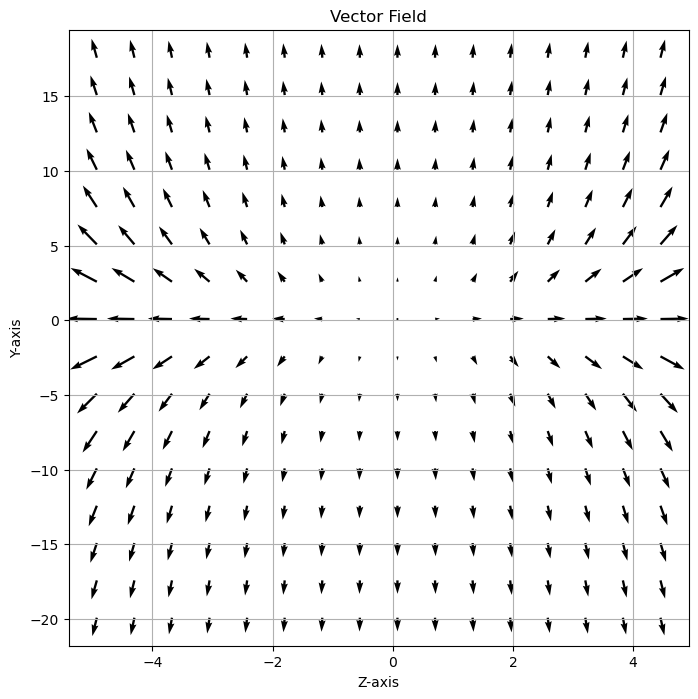

In [30]:
plt.figure(figsize=(8, 8))
plt.quiver(coords[2][128,::16,::4], coords[1][128,::16,::4], nhats[128,::16,::4,2], nhats[128,::16,::4,1], scale=1, scale_units='xy')
#plt.xlim(-2, 2)
#plt.ylim(-2, 2)
plt.xlabel('Z-axis')
plt.ylabel('Y-axis')
plt.title('Vector Field')
plt.grid()
plt.show()

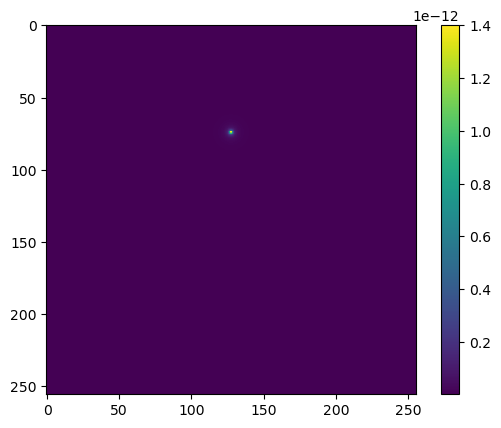

In [31]:
B_los_square = ((nhats*B_field)).sum(axis=-1)**2
plt.imshow(B_los_square[:,:,32])
plt.colorbar()

In [32]:
B_trans = (B_field_square-B_los_square)**0.5
#B_trans = C_field*1e-6*6

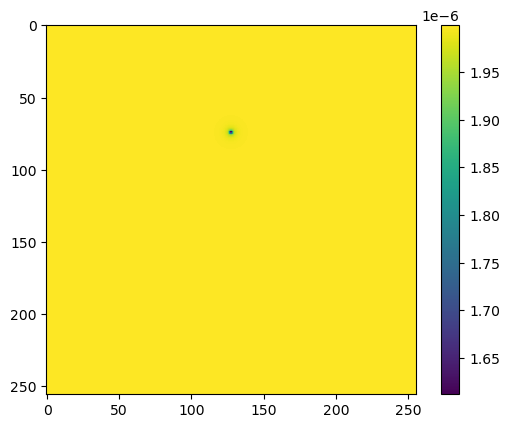

In [33]:
plt.imshow(B_trans[:,:,32])
plt.colorbar()
#B_trans.min()

In [42]:
%%time
emiss = synax.sync_emiss_I(30.,B_trans,C_field,spectral_index=3.)

CPU times: user 0 ns, sys: 3.06 ms, total: 3.06 ms
Wall time: 2.34 ms


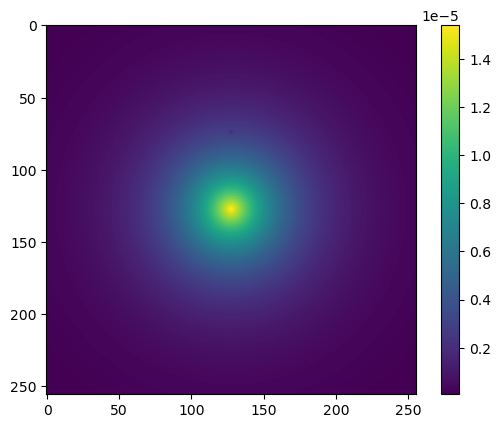

In [43]:
#emiss = emiss.at[100:110,10:20].set(1000)
plt.imshow(emiss[:,:,32])
plt.colorbar()

In [18]:
obtain_vmap = jax.vmap(lambda theta,phi:synax.obtain_positions(theta,phi,num_int_points=256))

In [19]:
nside = 256
n_pixs = np.arange(0,12*nside**2)
theta,phi = hp.pix2ang(nside,n_pixs)

theta.max()


3.138403212468682

In [20]:
poss,dls = obtain_vmap(theta,phi)
poss.shape

(786432, 3, 256)

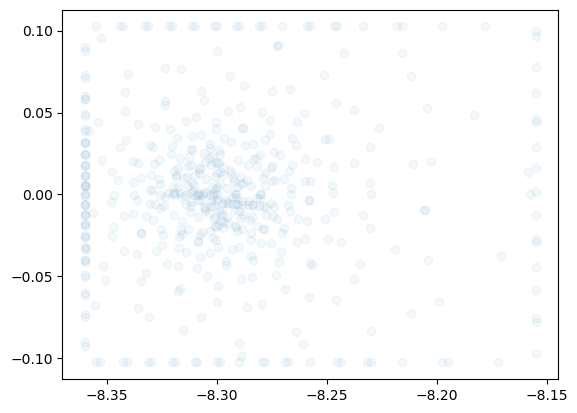

In [299]:
plt.scatter(poss[::100,0,10],poss[::100,1,10],alpha=0.05)

In [112]:
x_pos = poss[:,0].reshape(-1)
y_pos = poss[:,1].reshape(-1)
z_pos = poss[:,2].reshape(-1)
poss[:,0].shape

(786432, 256)

In [239]:
%%time
Sync_interp = interpax.interp3d(x_pos,y_pos,z_pos,xs,ys,zs,emiss,method='linear',extrap=True).reshape((786432, 256))
Sync_int = Sync_interp.sum(axis=-1)*dls

NameError: name 'x_pos' is not defined

In [35]:
interp_3d = jax.vmap(lambda pos: interpax.interp3d(pos[0],pos[1],pos[2],xs,ys,zs,emiss,method='linear',extrap=True))

In [36]:
%%time
Sync_interp = interp_3d(poss)
Sync_int = Sync_interp.sum(axis=-1)*dls
Sync_int.min()

CPU times: user 185 ms, sys: 38.7 ms, total: 224 ms
Wall time: 221 ms


Array(4.309884e-07, dtype=float32)

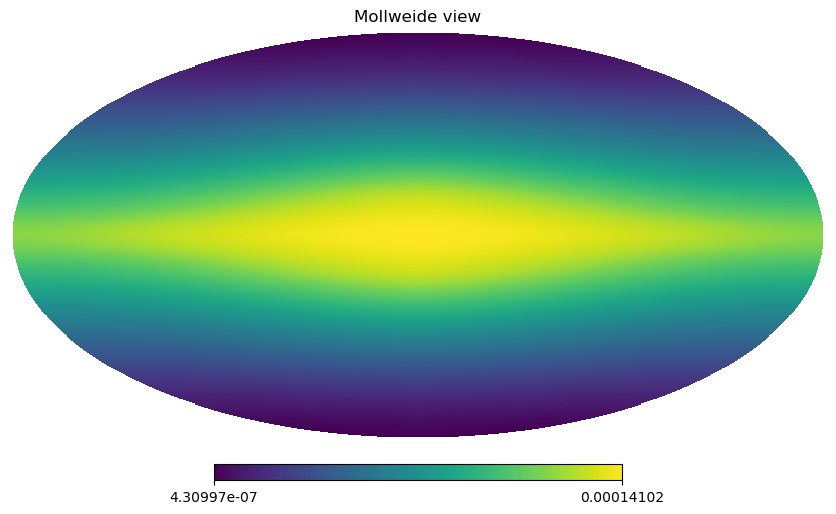

In [37]:
from copy import copy
hp.mollview(Sync_int,norm='hist')

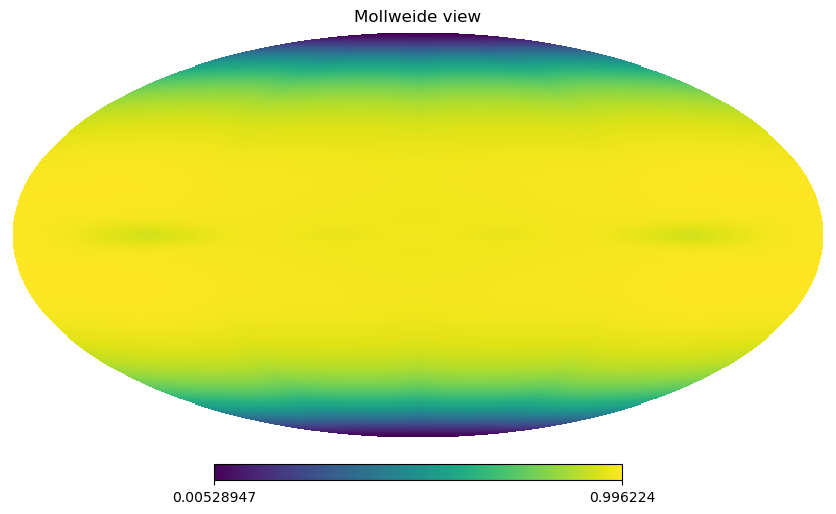

In [38]:
hammurabi_output = np.load('../../SyncEmiss/maps_30.npy')
hp.mollview(hammurabi_output/Sync_int)


(array([   64.,    60.,    58.,    58.,    60.,    65.,    63.,    60.,
           68.,    63.,    67.,    66.,    68.,    63.,    69.,    75.,
           78.,    62.,    78.,    80.,    68.,    83.,    82.,    78.,
           88.,    79.,    88.,    90.,    88.,    90.,    93.,   104.,
           89.,   105.,   102.,   102.,   105.,   106.,   115.,   116.,
          118.,   117.,   124.,   126.,   124.,   141.,   134.,   140.,
          145.,   146.,   152.,   161.,   162.,   172.,   164.,   177.,
          183.,   185.,   199.,   201.,   212.,   216.,   223.,   235.,
          232.,   265.,   258.,   271.,   289.,   291.,   312.,   316.,
          343.,   356.,   376.,   392.,   410.,   440.,   458.,   492.,
          516.,   558.,   589.,   638.,   677.,   747.,   800.,   864.,
          956.,  1050.,  1171.,  1308.,  1503.,  1870.,  2302.,  2929.,
         4065., 10986., 18826., 13635.]),
 array([6.57882410e-05, 1.00272000e-02, 1.99886132e-02, 2.99500246e-02,
        3.99114378e-02

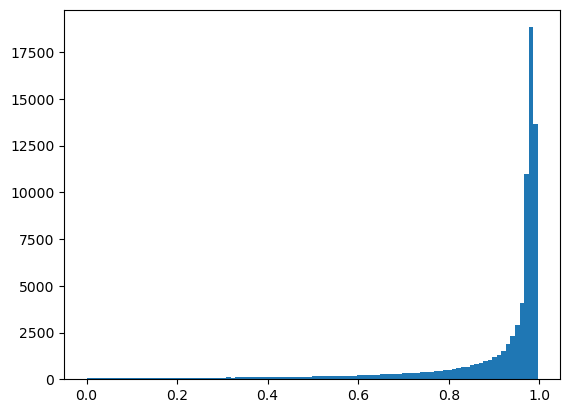

In [39]:
plt.hist((hammurabi_output/Sync_int)[::10],bins=100)

In [27]:
def calc_map(B_field):
    emiss = synax.sync_emiss_I(0.408,B_field,C_field,spectral_index=3.)
    interp_3d = jax.vmap(lambda pos: interpax.interp3d(pos[0],pos[1],pos[2],xs,ys,zs,emiss,method='linear',extrap=True))
    Sync_interp = interp_3d(poss)
    Sync_int = Sync_interp.sum(axis=-1)*dls
    return Sync_int.sum()

calc_grad = jax.value_and_grad(calc_map)

In [29]:
%%time
calc_grad(B_trans)

CPU times: user 109 ms, sys: 50.1 ms, total: 159 ms
Wall time: 165 ms


(Array(402876.47, dtype=float32),
 Array([[[ 1.3340129e+00,  1.5355474e+00,  1.8085393e+00, ...,
           1.8212748e+00,  1.2916493e+00,  7.0390314e-01],
         [ 2.8586087e-01,  6.7290813e-01,  7.5681561e-01, ...,
           1.1383456e+00,  6.6893399e-01,  1.9143634e-01],
         [ 1.9459748e-01,  7.7375555e-01,  1.4268234e+00, ...,
           3.7105525e-01,  2.2124052e-01,  5.7131571e-01],
         ...,
         [ 3.8417175e-01,  9.3197584e-01,  6.9514024e-01, ...,
           1.2549381e+00,  7.2381473e-01,  3.3626688e-01],
         [ 1.2040296e-01,  6.5885580e-01,  2.9291350e-01, ...,
           2.9862019e-01,  9.6074271e-01,  3.8290301e-01],
         [ 4.1124454e-01,  7.2403800e-01,  1.2275702e+00, ...,
           8.1481344e-01,  5.7880622e-01,  4.0420243e-01]],
 
        [[ 5.8700061e-01,  7.5352031e-01,  6.6836965e-01, ...,
           1.1284511e+00,  1.0663204e+00,  4.9275649e-01],
         [ 1.3305855e-01, -1.8304070e-06,  0.0000000e+00, ...,
           1.9407278e-06,  1.787

In [21]:
jnp.linspace(0,1,2)

Array([0., 1.], dtype=float32)

In [308]:
import scipy.constants as const

q_converter = 1/(4*np.pi*const.epsilon_0)**0.5

B_converter = (4*np.pi/const.mu_0)**0.5

freq_irrelavent_const = (const.e*q_converter)**3/(const.electron_mass*const.speed_of_light**2)*(1/(np.pi*2))*(np.sqrt(3)/(8*np.pi))*1e19 # moves kpc = 1e16 km here.

elect_combi = 2/3*const.electron_mass*const.speed_of_light/(const.e*q_converter)

kpc = 3.08567758

temp_covert = (const.hbar*1e9)/(const.Boltzmann*2.725)
#return _t*(np.exp(p)-1.)**2/(p**2*np.exp(p))

@jax.jit
def sync_I_const(freq,spectral_index: float=3.):
    
    gamma_func_1 = jax.scipy.special.gamma(spectral_index/4.-1/12.)
    
    gamma_func_2_process = (2e-4*B_converter)**(spectral_index/2.+0.5)/(spectral_index+1)*jax.scipy.special.gamma(spectral_index/4+19/12.)# the transition from micro-Gauss to tesla is here.
    
    omega = 2*jnp.pi*freq*1e9
    
    freq_irrelavent = freq_irrelavent_const/(2*const.Boltzmann*freq**2*1e18/(const.speed_of_light**2))
    
    consts = freq_irrelavent*(omega*elect_combi)**(0.5-spectral_index/2)*gamma_func_1*gamma_func_2_process
    
    p = freq*temp_covert
    
    return consts*kpc*(jnp.exp(p)-1.)**2/(p**2*jnp.exp(p))*jnp.pi

In [309]:
sync_I_const(30)

Array(11751.51832803, dtype=float64)

In [124]:
(const.hbar*1*1e9)/(const.Boltzmann*2.725)

0.002803021131103757

In [24]:
10**-1.05

0.08912509381337455

In [25]:
10**-0.91

0.12302687708123815

In [56]:
const.electron_mass

9.1093837015e-31

In [84]:
const.e**3

4.1127393005630515e-57

In [65]:
const.electron_mass*const.speed_of_light**2

8.187105776823886e-14

In [77]:
jax.scipy.special.gamma(2./4+19/12.)

Array(1.0381436, dtype=float32, weak_type=True)

In [29]:
((B_field**2).sum(axis=-1)**0.5).min()

Array(1.999966e-06, dtype=float64)

In [215]:
hp.nside2npix(256)

786432